In [2]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf

In [3]:
# hyperparameters
split = (0.85);
sequence_length = 7;
epochs = 50
learning_rate = 0.02

In [4]:


# loading data
stock_data = pd.read_csv("./NVDA.csv")
news_data = pd.read_csv("./NVDA.csv")
ma_data = pd.read_csv("./NVDA.csv")
change_data = pd.read_csv("./NVDA.csv")
count_data = pd.read_csv("./NVDA.csv")
# Define columns

In [ ]:
# Define columns
stock_column = ['Adj Close']
news_column = ['sentiment']
ma_column = ['moving_avg_7']
change_column = ['change']
count_column = ['news_count']
len_stock_data = stock_data.shape[0]

In [6]:

# splitting data to train and test
train_examples = int(len_stock_data * split)

# Split each feature into train and test
train = stock_data.get(stock_column).values[:train_examples]
train_sentiment = news_data.get(news_column).values[:train_examples]
train_ma = ma_data.get(ma_column).values[:train_examples]
train_change = change_data.get(change_column).values[:train_examples]
train_count = count_data.get(count_column).values[:train_examples]

test = stock_data.get(stock_column).values[train_examples:]
test_sentiment = news_data.get(news_column).values[train_examples:]
test_ma = ma_data.get(ma_column).values[train_examples:]
test_change = change_data.get(change_column).values[train_examples:]
test_count = count_data.get(count_column).values[train_examples:]

# Get lengths
len_train = train.shape[0]
len_test = test.shape[0]

# normalizing data
scaler_stock = MinMaxScaler()
scaler_sentiment = MinMaxScaler()
scaler_ma = MinMaxScaler()
scaler_change = MinMaxScaler()

# Transform each feature
train = scaler_stock.fit_transform(train)
test = scaler_stock.transform(test)

train_sentiment = scaler_sentiment.fit_transform(train_sentiment)
test_sentiment = scaler_sentiment.transform(test_sentiment)

train_ma = scaler_ma.fit_transform(train_ma)
test_ma = scaler_ma.transform(test_ma)

train_change = scaler_change.fit_transform(train_change)
test_change = scaler_change.transform(test_change)

# splitting training data to x and y
X_train = []
for i in range(len_train - sequence_length):
    # Combine all features for each sequence
    sequence = np.column_stack((
        train[i:i + sequence_length],
        train_sentiment[i:i + sequence_length],
        train_ma[i:i + sequence_length],
        train_change[i:i + sequence_length]
    ))
    X_train.append(sequence)

X_train = np.array(X_train).astype(float)
y_train = np.array(train[sequence_length:]).astype(float)

# splitting testing data to x and y
X_train, y_train = [], []
for i in range(sequence_length, len(train)):
    # Collect the past `sequence_length` days of stock data
    stock_sequence = train[i-sequence_length:i].reshape(-1).tolist()
    # Append the current day’s sentiment as a separate feature
    stock_sequence.append(train_sentiment[i][0])
    X_train.append(stock_sequence)
    y_train.append(train[i][0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Preparing testing data with lagged stock features and current day sentiment
X_test, y_test = [], []
for i in range(sequence_length, len(test)):
    stock_sequence = test[i-sequence_length:i].reshape(-1).tolist()
    stock_sequence.append(test_sentiment[i][0])
    X_test.append(stock_sequence)
    y_test.append(test[i][0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Defining the LSTM model
def model_create():
    tf.random.set_seed(1234)
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(X_train.shape[1], 1)),  # Adjust input shape
        tf.keras.layers.LSTM(units=70, activation="tanh", return_sequences=True),
        tf.keras.layers.LSTM(units=30, activation="tanh", return_sequences=True),
        tf.keras.layers.LSTM(units=10, activation="tanh"),
        tf.keras.layers.Dense(units=1, activation="linear")
    ])
    model.compile(
        loss="mean_squared_error",
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
    )
    model.fit(
        X_train.reshape(X_train.shape[0], X_train.shape[1], 1),  # Reshape for LSTM
        y_train,
        epochs=epochs,
        verbose=1
    )
    return model

# Inverting normalization for y_test
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1,)

# Prediction function
def predict(model):
    predictions = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
    predictions = scaler.inverse_transform(predictions).reshape(-1,)
    return predictions

# Evaluation function
def evaluate(predictions):
    mae = mean_absolute_error(predictions, y_test_rescaled)
    mape = mean_absolute_percentage_error(predictions, y_test_rescaled)
    accuracy = (1 - mape) * 100  # Accuracy in percentage
    return mae, mape * 100, accuracy

# Trial run
def run_model(n):
    total_mae = total_mape = total_acc = 0
    for _ in range(n):
        model = model_create()
        predictions = predict(model)
        mae, mape, acc = evaluate(predictions)
        total_mae += mae
        total_mape += mape
        total_acc += acc
    return (total_mae / n), (total_mape / n), (total_acc / n)

# Run model and print results
mae, mape, acc = run_model(1)




# Visualization function
def plot_results(predictions, y_test):
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(15, 6))
    plt.plot(y_test, label='Actual', color='blue')
    plt.plot(predictions, label='Predicted', color='red')
    plt.title('Stock Price Prediction vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()


In [7]:
mae, mape, acc, preds = run_model(1)

print(f"Mean Absolute Error = {mae}")
print(f"Mean Absolute Percentage Error = {mape}%")
print(f"Accuracy = {acc}")

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0409
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.9176e-04
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.7549e-04
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6260e-04
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0292e-04
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1139e-04
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0899e-04
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1153e-04
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.1688e-04
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1605e-04
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0859e-04
Epoch 13/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9701e-04
Epoch 14/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8316e-04
Epoch 15/50
23/23 ━━━━━━━━━━━━━━━━━━━

Model saved as 'trained_lstm_model.h5'
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
Mean Absolute Error = 3.466018861339937
Mean Absolute Percentage Error = 0.03097475529571672%
Accuracy = 0.9690252447042833


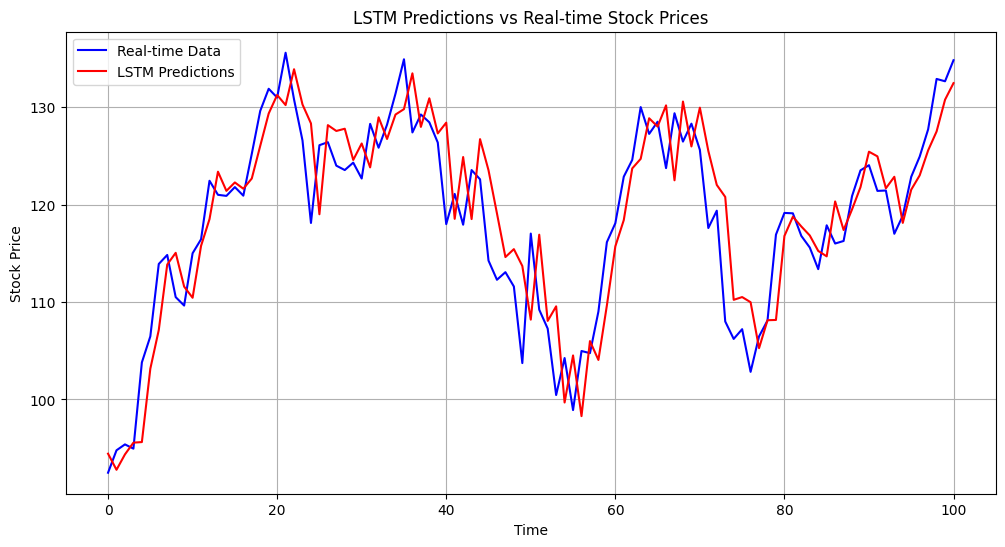

In [24]:

from matplotlib import pyplot as plt
# Create a time axis for plotting

time_axis = range(len(y_test))

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(time_axis, y_test, label='Real-time Data', color='blue')
plt.plot(time_axis, preds, label='LSTM Predictions', color='red')
plt.title('LSTM Predictions vs Real-time Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()